In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

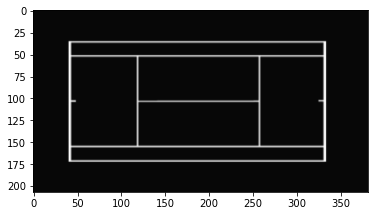

In [73]:
tnt = cv2.imread(r'tnt.PNG')

img = cv2.cvtColor(tnt, cv2.COLOR_BGR2GRAY)
img_original = img.copy()
plt.imshow(img, cmap='gray')

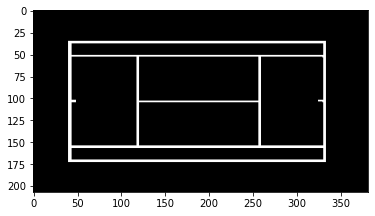

In [74]:
ret5, thresh5 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
plt.imshow(thresh5, cmap='gray')

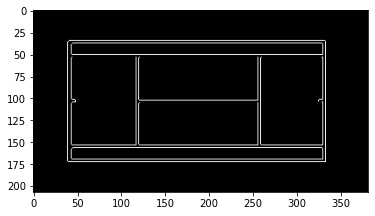

In [75]:
edges = cv2.Canny(thresh5,50,100,apertureSize=3)
plt.imshow(edges, cmap='gray')  

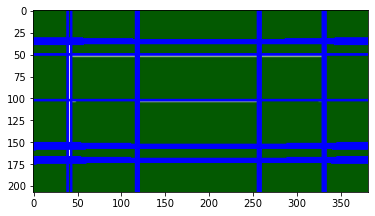

In [81]:
lines1 = cv2.HoughLines(edges,1,np.pi/180,100)

for i in range(len(lines1)):
    for rho, theta in lines1[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0+1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 -1000*(a))

        cv2.line(tnt,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(tnt)  

# Find Intersections

In [77]:
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented


In [60]:
segmented = segment_by_angle_kmeans(lines)
segmented

[[array([[172.       ,   1.5707964]], dtype=float32),
  array([[34.       ,  1.5707964]], dtype=float32),
  array([[50.       ,  1.5707964]], dtype=float32),
  array([[169.       ,   1.5707964]], dtype=float32),
  array([[37.       ,  1.5707964]], dtype=float32),
  array([[156.       ,   1.5707964]], dtype=float32)],
 [array([[153.       ,   1.5707964]], dtype=float32)]]

In [61]:
def intersection(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.

    Returns closest integer pixel locations.
    See https://stackoverflow.com/a/383527/5087436
    """
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]


def segmented_intersections(lines):
    """Finds the intersections between groups of lines."""

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [62]:
intersections = segmented_intersections(segmented)

TypeError: Image data of dtype object cannot be converted to float

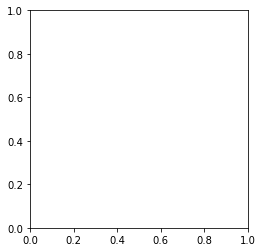

In [63]:
plt.imshow(intersections)

Found lines: 1245
Segmented lines into two groups: 591, 654


True

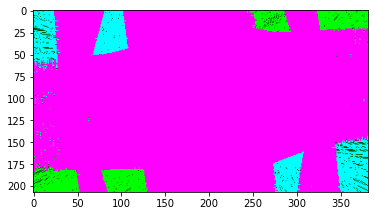

In [82]:
import numpy as np
import cv2
from collections import defaultdict
import sys

img = cv2.imread("tnt.PNG")
#img = cv2.imread("sudoku.jpg")


def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """
    Group lines by their angle using k-means clustering.

    Code from here:
    https://stackoverflow.com/a/46572063/1755401
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))

    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # Get angles in [0, pi] radians
    angles = np.array([line[0][1] for line in lines])

    # Multiply the angles by two and find coordinates of that angle on the Unit Circle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)] for angle in angles], dtype=np.float32)

    # Run k-means
    if sys.version_info[0] == 2:
        # python 2.x
        ret, labels, centers = cv2.kmeans(pts, k, criteria, attempts, flags)
    else: 
        # python 3.x, syntax has changed.
        labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]

    labels = labels.reshape(-1) # Transpose to row vector

    # Segment lines based on their label of 0 or 1
    segmented = defaultdict(list)
    for i, line in zip(range(len(lines)), lines):
        segmented[labels[i]].append(line)

    segmented = list(segmented.values())
    print("Segmented lines into two groups: %d, %d" % (len(segmented[0]), len(segmented[1])))

    return segmented


def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]


def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections


def drawLines(img, lines, color=(0,0,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1,y1), (x2,y2), color, 1)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

blur = cv2.medianBlur(gray, 5)

# Make binary image
adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
thresh_type = cv2.THRESH_BINARY_INV
bin_img = cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)
plt.imshow(bin_img)

# Detect lines
rho = 2
theta = np.pi/180
thresh = 100
lines = cv2.HoughLines(bin_img, rho, theta, thresh)

if sys.version_info[0] == 2:
    # python 2.x
    # Re-shape from 1xNx2 to Nx1x2
    temp_lines = []
    N = lines.shape[1]
    for i in range(N):
        rho = lines[0,i,0]
        theta = lines[0,i,1]
        temp_lines.append( np.array([[rho,theta]]) )
    lines = temp_lines

print("Found lines: %d" % (len(lines)))

# Draw all Hough lines in red
img_with_all_lines = np.copy(img)
drawLines(img_with_all_lines, lines)
plt.imshow(img_with_all_lines)
cv2.imwrite("all_lines.jpg", img_with_all_lines)

# Cluster line angles into 2 groups (vertical and horizontal)
segmented = segment_by_angle_kmeans(lines, 2)

# Find the intersections of each vertical line with each horizontal line
intersections = segmented_intersections(segmented)

img_with_segmented_lines = np.copy(img)

# Draw vertical lines in green
vertical_lines = segmented[1]
img_with_vertical_lines = np.copy(img)
drawLines(img_with_segmented_lines, vertical_lines, (0,255,0))

# Draw horizontal lines in yellow
horizontal_lines = segmented[0]
img_with_horizontal_lines = np.copy(img)
drawLines(img_with_segmented_lines, horizontal_lines, (0,255,255))

# Draw intersection points in magenta
for point in intersections:
    pt = (point[0][0], point[0][1])
    length = 5
    cv2.line(img_with_segmented_lines, (pt[0], pt[1]-length), (pt[0], pt[1]+length), (255, 0, 255), 1) # vertical line
    cv2.line(img_with_segmented_lines, (pt[0]-length, pt[1]), (pt[0]+length, pt[1]), (255, 0, 255), 1)

plt.imshow(img_with_segmented_lines)
cv2.imwrite("intersection_points.jpg", img_with_segmented_lines)